In [1]:
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import LayerNorm
from torch_geometric.nn import global_add_pool

import numpy as np
import random
from itertools import permutations

from matplotlib import pyplot as plt

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [2]:

# REINFROCE Network
class GCN(nn.Module):
    def __init__(self, state_space=None,
                       action_space=None,
                       num_hidden_layer=2,
                       hidden_dim=None,
                       learning_rate=None):

        super(GCN, self).__init__()

        # space size check
        assert state_space is not None, "None state_space input: state_space should be assigned."
        assert action_space is not None, "None action_space input: action_space should be assigned"

        if hidden_dim is None:
            hidden_dim = state_space * 2

        self.conv1 = GCNConv(2, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, action_space)
        self.layer_norm = LayerNorm(hidden_dim)

        self.roll_out = []
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def put_data(self, data):
        self.roll_out.append(data)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = global_add_pool(self.layer_norm(x), torch.LongTensor([0 for _ in range(4)]).to(device))
        x = self.linear1(x)
        x = x.relu()
        x = self.linear2(x)
        out = F.log_softmax(x, dim=1)
        return out

    def train(self, gamma):
        R = 0
        G = []
        G_t = 0
        
        # Whitening baseline
        for r, prob in self.roll_out[::-1]:
            G_t = r + gamma * G_t
            G.append(G_t)
        G = np.array(G)
        G_mean = G.mean()
        G_std  = G.std()
        self.optimizer.zero_grad()

        for r, prob in self.roll_out[::-1]:
            R = r + gamma * R
            loss = -prob * ((R-G_mean) / G_std)
            loss.backward()
        self.optimizer.step()
        self.roll_out = []


In [3]:


def create_torch_graph_data(data):

    edge_index = list(permutations([i for i in range(4)], 2))
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_index = edge_index.t().contiguous()



    # data = data[0]
    # node_feature = [[data[0]],[data[1]],[data[2]],[data[3]]]
    # print(data)
    node_feature = [[data[0], data[1]],[data[2], data[3]],[data[0], data[3]],[data[1], data[2]]]
    # node_feature = [[data[0], data[3]],[data[1], data[2]]]
   
    node_feature = torch.tensor(node_feature, dtype=torch.float)

    data = Data(x=node_feature, edge_index=edge_index)

    return data
    
def seed_torch(seed):
        torch.manual_seed(seed)
        if torch.backends.cudnn.enabled:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True

def save_model(model, path='default.pth'):
        torch.save(model.state_dict(), path)


In [4]:



# Determine seeds
model_name = "REINFORCE"
env_name = "CartPole-v1"
seed = 10
exp_num = 'SEED_'+str(seed)
# Set gym environment
env = gym.make(env_name)
if torch.cuda.is_available():
    device = torch.device("cuda")
else :
    device = torch.device("cpu")
np.random.seed(seed)
random.seed(seed)
seed_torch(seed)
# env.seed(seed)
# set parameters
learning_rate = 0.0005
episodes = 100
discount_rate = 0.99
print_interval = 10
model = GCN(state_space=env.observation_space.shape[0],
                         action_space=env.action_space.n,
                         num_hidden_layer=0,
                         hidden_dim=128,
                         learning_rate=learning_rate).to(device)


/home/geekboyboss/miniconda3/envs/pyg/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/geekboyboss/miniconda3/envs/pyg/lib/python3.11/site-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


(array([ 0.03153568, -0.22506788, -0.00415961,  0.31131992], dtype=float32), 1.0, False, False, {})
(array([ 0.01863171, -0.6152811 ,  0.01412055,  0.8960213 ], dtype=float32), 1.0, False, False, {})
(array([-0.00988574, -0.615899  ,  0.05590316,  0.91063863], dtype=float32), 1.0, False, False, {})
(array([-0.03063525, -0.61764944,  0.08683667,  0.95110923], dtype=float32), 1.0, False, False, {})
(array([-0.05926476, -1.0101283 ,  0.13125412,  1.5936327 ], dtype=float32), 1.0, False, False, {})
(array([-0.10359813, -1.402995  ,  0.20161067,  2.2627113 ], dtype=float32), 1.0, False, False, {})
(array([ 0.00205099,  0.18517736,  0.0153117 , -0.26157984], dtype=float32), 1.0, False, False, {})
(array([ 0.01335608,  0.18481533, -0.00090778, -0.25355247], dtype=float32), 1.0, False, False, {})
(array([ 0.01684652,  0.18491353, -0.00520195, -0.2557193 ], dtype=float32), 1.0, False, False, {})
(array([ 0.02814697,  0.18513383, -0.02131711, -0.2606237 ], dtype=float32), 1.0, False, False, {})


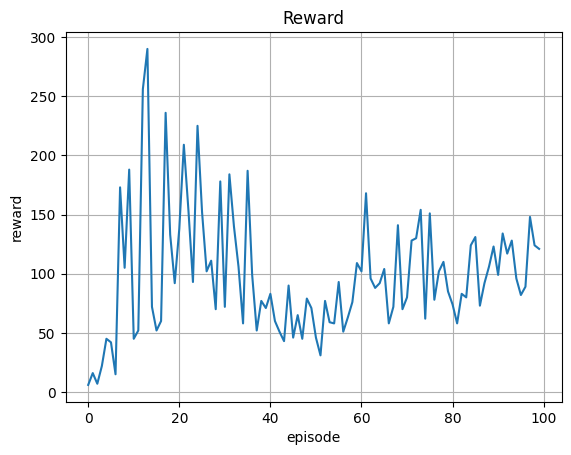

In [5]:

score = 0
score_list = []
for epi in range(episodes):
    s = env.reset()[0]
    done = False
    step = 0
    while not done:
        # if epi%print_interval == 0:
        #     env.render()
        # Get action
        s_g = create_torch_graph_data(s)
        a_prob = model(s_g.x.to(device), s_g.edge_index.to(device))
        a_distrib = Categorical(torch.exp(a_prob))
        a = a_distrib.sample()
        # Interaction with Environment
        # print(env.step(a.item()))
        s_prime, r, done, _, _ = env.step(a.item())
        model.put_data((r, a_prob[0][a]))
        s = s_prime
        score += r
        step += 1
    
    model.train(discount_rate)
    score_list.append(score)
    score = 0.0
    # Logging/
    if epi%print_interval==0 and epi!=0:
        print("# of episode :{}, avg score : {}".format(epi, sum(score_list[-print_interval:])/print_interval))
        
env.close()
plt.plot(score_list)
plt.title('Reward')
plt.ylabel('reward')
plt.xlabel('episode')
plt.grid()
plt.show()